## Import the required libraries

In [1]:
from enum import IntEnum
from itertools import product
from numpy.lib.stride_tricks import sliding_window_view
from pprint import pprint
from scipy import integrate
from tabulate import tabulate
from tqdm import tqdm

import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

%matplotlib inline

# Solution for Problem 1-c in Computational Assignment - Quantized Approximation Methods

## Quantization of state space

In the following code piece, $T_0$ and $T_1$ are the transition kernels for $u = 0$ and $u = 1$, respectively. Given the boundaries of a set A, the functions calculate the probabilities

$$
P(x_{t+1} \in A \vert x_t = z_0, u_t = 0) = 2 \int_Axdx
$$

$$
P(x_{t+1} \in A \vert x_t = z_0, u_t = 1) = 2 \int_A(1-x)dx
$$

In [2]:
state_space = [0, 1]
action_space = [0, 1]

In [3]:
def T_0(left_boundary, right_boundary):
    return integrate.quad(lambda x: 2 * x, left_boundary, right_boundary)[0]

def T_1(left_boundary, right_boundary):
    return integrate.quad(lambda x: 2 * (1 - x), left_boundary, right_boundary)[0]

In [4]:
def T(left_boundary, right_boundary, action):
    if action == 0:
        return T_0(left_boundary, right_boundary)
    elif action == 1:
        return T_1(left_boundary, right_boundary)
    raise ValueError('Invalid Action')

The following code piece creates the quantized state space. 

In [5]:
class State:
    def __init__(self, left_boundary, right_boundary, include_right=False):
        self.left_boundary = left_boundary
        self.right_boundary = right_boundary
        self.include_right = include_right
    
    def __contains__(self, item):
        if self.include_right:
            return self.left_boundary <= item <= self.right_boundary
        else:
            return self.left_boundary <= item < self.right_boundary
    
    def __str__(self):
        return f'State({self.left_boundary}, {self.right_boundary})'
    
    def __repr__(self):
        return str(self)
    
    def __int__(self):
        index = self.left_boundary / (self.right_boundary - self.left_boundary)
        return int(np.round(index))

In [6]:
class States(list):
    def __init__(self, n):
        self._create_states(n)
    
    def find(self, number):
        for state in self:
            if number in state:
                return state
        raise ValueError('number out of bounds')
        
    def construct_P(self):
        return np.array([
            [T(state.left_boundary, state.right_boundary, action)
             for action in action_space]
            for state in self
        ])
    
    def _create_states(self, n):
        quantized_boundaries = np.linspace(*state_space, n + 1)
        n_decimals = int(np.ceil(np.log10(n)))
        for i in range(len(quantized_boundaries) - 2):
            left_boundary = np.round(quantized_boundaries[i], decimals=n_decimals)
            right_boundary = np.round(quantized_boundaries[i + 1], decimals=n_decimals)
            self.append(State(left_boundary, right_boundary))
        left_boundary = np.round(quantized_boundaries[i + 1], decimals=n_decimals)
        right_boundary = np.round(quantized_boundaries[i + 2], decimals=n_decimals)
        self.append(State(left_boundary, right_boundary, include_right=True))

Let us quantize the state space into 10 bins.

In [7]:
states = States(n=10)

print(states)

[State(0.0, 0.1), State(0.1, 0.2), State(0.2, 0.3), State(0.3, 0.4), State(0.4, 0.5), State(0.5, 0.6), State(0.6, 0.7), State(0.7, 0.8), State(0.8, 0.9), State(0.9, 1.0)]


In [8]:
P = states.construct_P()

print(P)

[[0.01 0.19]
 [0.03 0.17]
 [0.05 0.15]
 [0.07 0.13]
 [0.09 0.11]
 [0.11 0.09]
 [0.13 0.07]
 [0.15 0.05]
 [0.17 0.03]
 [0.19 0.01]]


## Create cost function

In [9]:
def c(state, u, eta):
    return integrate.quad(lambda x: (eta - x) * u, state.left_boundary, state.right_boundary)[0]

## Apply Q-Learning algorithm on the quantized state space

Let the discount factor $\beta = 0.9$

In [10]:
beta = 0.9

In [11]:
def alpha(state, action, n_occurences):
    return 1 / (1 + n_occurences[int(state)][action])

In [12]:
def get_starting_state(states):
    return np.random.choice(states)

In [13]:
def get_next_state(state, action):
    return np.random.choice(states, p=P.T[action])

In [14]:
def epsilon_decay_schedule(episode):
    return 1 / np.log10(10 + episode)

def epsilon_greedy_policy(state, q_values, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(action_space)
    else:
        return np.argmin(q_values[int(state)])

In [15]:
def learn(eta, beta=beta, max_iterations=1_000_000):
    q_values = np.zeros((len(states), len(action_space)))
    n_occurences = np.zeros((len(states), len(action_space)))
    all_q_values = [q_values]

    state = get_starting_state(states)
    for iteration in tqdm(range(1, max_iterations + 1), desc='eta={:.2f}'.format(eta)):
        epsilon = epsilon_decay_schedule(iteration)
        action = epsilon_greedy_policy(state, q_values, epsilon)
        cost = c(state, action, eta)

        next_state = get_next_state(state, action)
        td = cost + beta * q_values[int(next_state)].min() - q_values[int(state)][action]

        q_values[int(state)][action] += alpha(state, action, n_occurences) * td
        n_occurences[int(state)][action] += 1

        state = next_state
        all_q_values.append(q_values.copy())
        
    return np.array(all_q_values)

We will try the algorithm for different eta values.

In [16]:
etas = np.linspace(0, 0.8, 5)

print(etas)

[0.  0.2 0.4 0.6 0.8]


In [17]:
q_values = [(eta, learn(eta, max_iterations=2_000_000)) for eta in etas]

eta=0.80: 100%|████████████████████| 2000000/2000000 [03:10<00:00, 10516.36it/s]


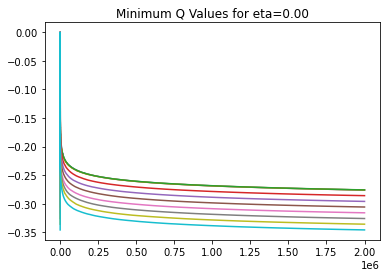

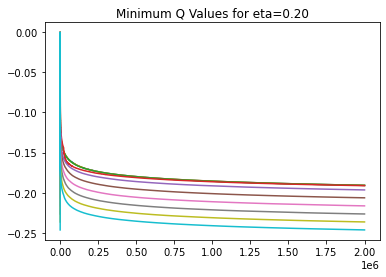

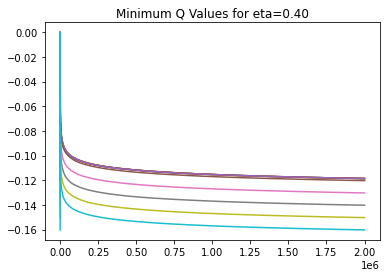

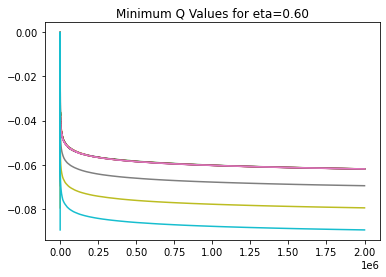

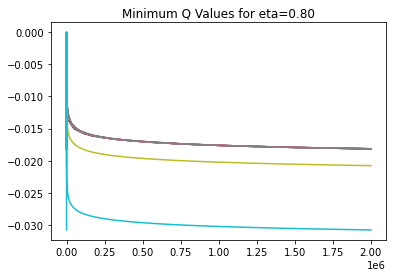

In [18]:
for eta, q in q_values:
    plt.figure()
    plt.plot(q.min(axis=-1))
    plt.title('Minimum Q Values for eta={:.2f}'.format(eta))
    plt.show()

Let's now see the optimal values and policy.

In [19]:
for eta, q in q_values:
    print(tabulate(
        np.concatenate([
            np.array(states)[np.newaxis], 
            q[-1].min(axis=-1)[np.newaxis],
            q[-1].argmin(axis=-1)[np.newaxis]
        ]).T,
        headers=['eta={:.2f}'.format(eta), 'Optimal Values', 'Optimal Action'],
        tablefmt='fancy_grid')
    )

╒═════════════════╤══════════════════╤══════════════════╕
│ eta=0.00        │   Optimal Values │   Optimal Action │
╞═════════════════╪══════════════════╪══════════════════╡
│ State(0.0, 0.1) │        -0.275974 │                0 │
├─────────────────┼──────────────────┼──────────────────┤
│ State(0.1, 0.2) │        -0.275974 │                0 │
├─────────────────┼──────────────────┼──────────────────┤
│ State(0.2, 0.3) │        -0.275809 │                1 │
├─────────────────┼──────────────────┼──────────────────┤
│ State(0.3, 0.4) │        -0.285845 │                1 │
├─────────────────┼──────────────────┼──────────────────┤
│ State(0.4, 0.5) │        -0.295922 │                1 │
├─────────────────┼──────────────────┼──────────────────┤
│ State(0.5, 0.6) │        -0.30572  │                1 │
├─────────────────┼──────────────────┼──────────────────┤
│ State(0.6, 0.7) │        -0.315854 │                1 │
├─────────────────┼──────────────────┼──────────────────┤
│ State(0.7, 0

We can observe that it is more encouraged to use the channel for lower $\eta$.

# Solution for Problem 1-d in Computational Assignment - Q-Learning for Partially Observed Models

## Enumerate the states

In [20]:
class States(IntEnum):
    BAD = 0
    GOOD = 1

## Enumerate the actions

In [21]:
class Actions(IntEnum):
    DO_NOTHING = 0
    REPAIR = 1

## Construct the one-step transition probability matrices

The failure probability $\eta$ and the success probability in the event of a repair $\alpha$ are not specified in the problem description. 

Let us take $\eta = 0.2$ and $\alpha = 0.9$.

In [22]:
eta = 0.2
alpha = 0.9

In [23]:
P_do_nothing = np.array([
    [1, 0],
    [eta, 1 - eta]
])

print(P_do_nothing)

[[1.  0. ]
 [0.2 0.8]]


In [24]:
P_repair = np.array([
    [1 - alpha, alpha],
    [0, 1]
])

print(P_repair)

[[0.1 0.9]
 [0.  1. ]]


In [25]:
P = np.concatenate([P_do_nothing[np.newaxis, ...], P_repair[np.newaxis, ...]], axis=0)

print(P)

[[[1.  0. ]
  [0.2 0.8]]

 [[0.1 0.9]
  [0.  1. ]]]


## Define the cost function

The costs are given as:

$$c(0, 0) = R$$

$$c(0, 1) = C$$

$$c(1, 0) = R$$

$$c(1, 1) = 0$$

with the constraint $0 < R < C$.

Let us take $R = 0.6$ and $C = 0.8$.

In [26]:
def c(x, u, R=0.6, C=0.8):
    if (x, u) == (States.BAD, Actions.REPAIR):
        return C
    elif (x, u) == (States.GOOD, Actions.REPAIR):
        return 0
    else:
        return R

## Define a function to get measurements

$P(Y = X) = 1 - \epsilon$ and $P(Y \neq X) = \epsilon$.

Let $\epsilon = 0.1$.

In [27]:
def get_measurement(x, epsilon=0.1):
    if np.random.rand() < epsilon:
        return States(not x)
    else:
        return States(x)

## Enumerate the windows

The windows are n-tuples that hold the measurements and actions in the following order:

$$(y_{t-N}, u_{t-N}, y_{t-N+1}, u_{t-N+1}, ..., y_{t-1}, u_{t-1}, y_{t})$$

Let n = 5.

In [28]:
windows = list(product(*[States, Actions] * 2 + [States]))

pprint(list(map(lambda window: [int(item) for item in window], windows)))

[[0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 1, 1],
 [0, 0, 1, 0, 0],
 [0, 0, 1, 0, 1],
 [0, 0, 1, 1, 0],
 [0, 0, 1, 1, 1],
 [0, 1, 0, 0, 0],
 [0, 1, 0, 0, 1],
 [0, 1, 0, 1, 0],
 [0, 1, 0, 1, 1],
 [0, 1, 1, 0, 0],
 [0, 1, 1, 0, 1],
 [0, 1, 1, 1, 0],
 [0, 1, 1, 1, 1],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 1, 0],
 [1, 0, 0, 1, 1],
 [1, 0, 1, 0, 0],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 1, 0],
 [1, 0, 1, 1, 1],
 [1, 1, 0, 0, 0],
 [1, 1, 0, 0, 1],
 [1, 1, 0, 1, 0],
 [1, 1, 0, 1, 1],
 [1, 1, 1, 0, 0],
 [1, 1, 1, 0, 1],
 [1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1]]


## Apply the Q learning algorithm to obtain the optimal solution

The discount factor $\beta$ is not specified in the problem description.

Let $\beta = 0.95$

In [29]:
beta = 0.95

In [30]:
def alpha(window, action, n_occurences):
    return 20 / (20 + n_occurences[windows.index(window)][action])

In [31]:
def get_starting_window():
    generator = np.random.default_rng()
    return tuple(generator.choice(windows, axis=0))

In [32]:
def get_next_state(state, action):
    return np.random.choice(States, p=P[action][state])

In [33]:
def get_next_window(window, action, next_state):
    return (*window[2:], action, next_state)

In [34]:
def epsilon_decay_schedule(episode):
    return 1 / np.log10(10 + episode)

def epsilon_greedy_policy(window, q_values, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(Actions)
    else:
        return np.argmin(q_values[windows.index(window)])

The Q values takes so many iterations to converge. Therefore, we cannot hold all the Q values due to the memory requirements. Thus, we will save them to a csv file and load the data later.

In [35]:
logs = [
    open(f'logs/q_values_window_{window_index}.csv', 'w+')
    for window_index in range(len(windows))
]

max_iterations = 100_000_000
q_values = np.zeros((len(windows), len(Actions)))
n_occurences = np.zeros((len(windows), len(Actions)))
for window_index, log_file in enumerate(logs):
    writer = csv.writer(log_file)
    writer.writerow(['Action 0', 'Action 1'])
    writer.writerow(q_values[window_index])


window = get_starting_window()
state = get_measurement(window[-1])
for iteration in tqdm(range(1, max_iterations + 1)):
    epsilon = epsilon_decay_schedule(iteration)
    action = epsilon_greedy_policy(window, q_values, epsilon)
    cost = c(state, action)
    
    next_state = get_next_state(state, action)
    next_measurement = get_measurement(state)
    next_window = get_next_window(window, action, next_measurement)
    
    td = cost + beta * q_values[windows.index(next_window)].min()\
            - q_values[windows.index(window)][action]
    
    q_values[windows.index(window)][action]\
        += alpha(window, action, n_occurences) * td
    
    n_occurences[windows.index(window)][action] += 1
    
    state = next_state
    window = next_window
    
    for window_index, log_file in enumerate(logs):
        writer = csv.writer(log_file)
        writer.writerow(q_values[window_index])

for log_file in logs:
    log_file.close()

100%|████████████████████████| 100000000/100000000 [11:36:40<00:00, 2392.34it/s]


The ipython kernel dies if we try to plot all the states in one loop. Let us plot the graphs in 4 different loops

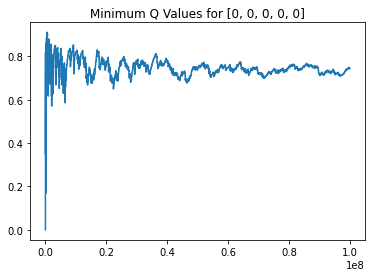

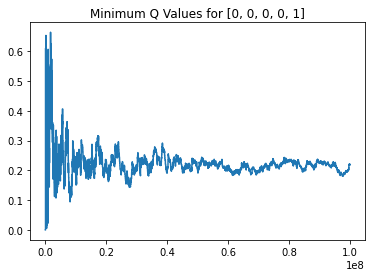

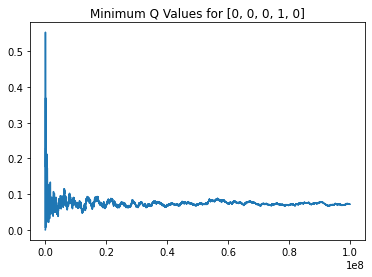

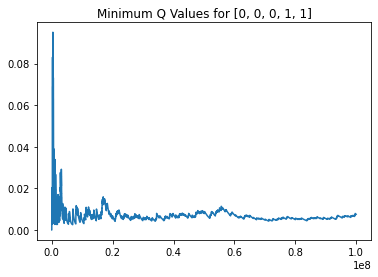

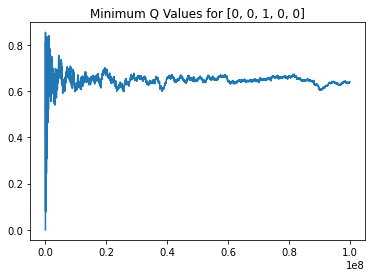

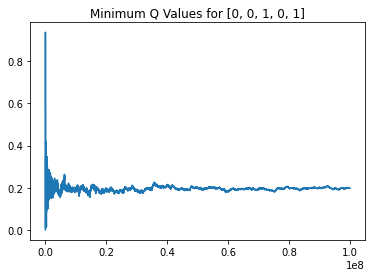

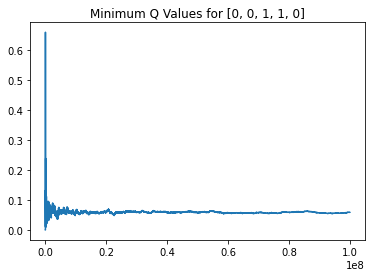

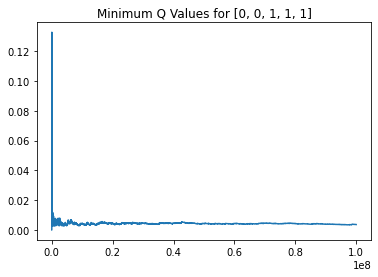

In [36]:
for i in range(0, 8):
    q_values = pd.read_csv(f'logs/q_values_window_{i}.csv').to_numpy()
    
    plt.figure()
    plt.plot(q_values.min(axis=-1))
    plt.title(f'Minimum Q Values for {str(list(map(lambda x: int(x), windows[i])))}')
    plt.show()

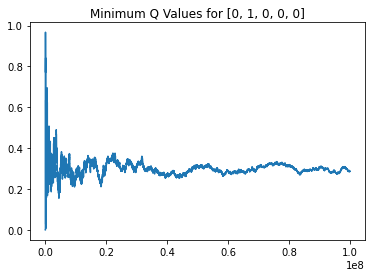

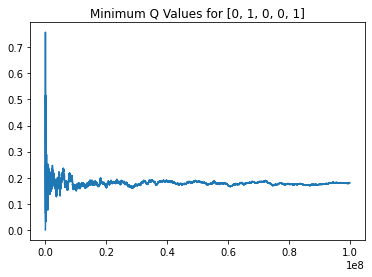

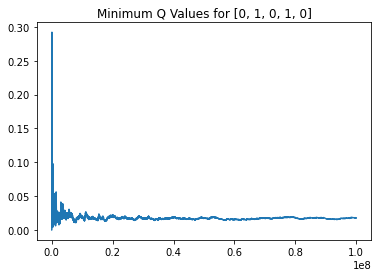

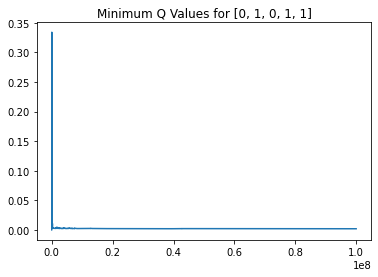

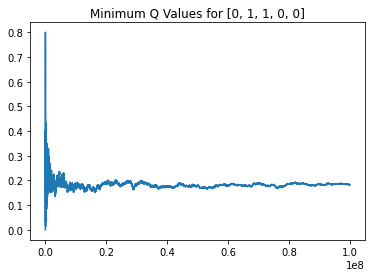

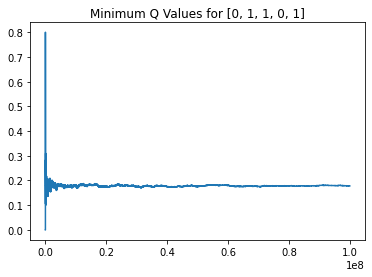

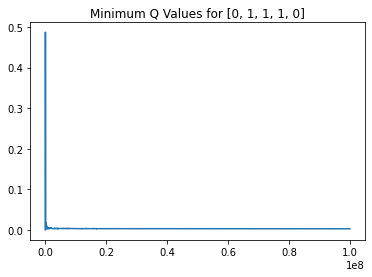

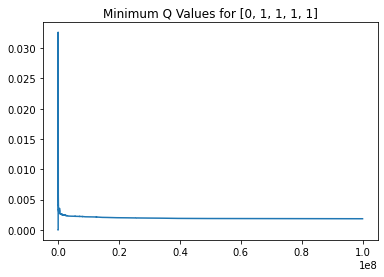

In [37]:
for i in range(8, 16):
    q_values = pd.read_csv(f'logs/q_values_window_{i}.csv').to_numpy()
    
    plt.figure()
    plt.plot(q_values.min(axis=-1))
    plt.title(f'Minimum Q Values for {str(list(map(lambda x: int(x), windows[i])))}')
    plt.show()

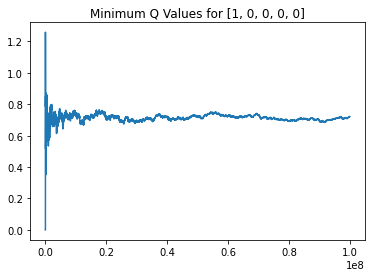

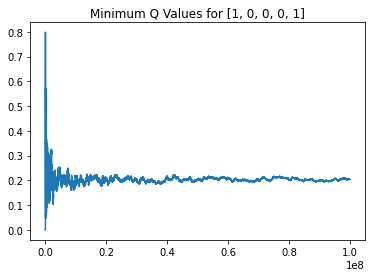

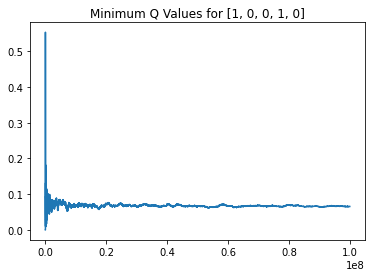

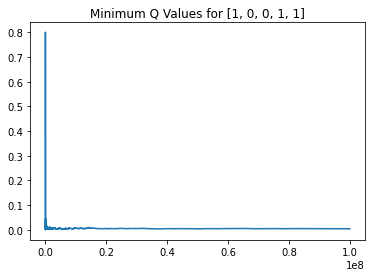

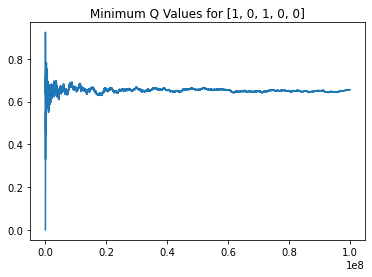

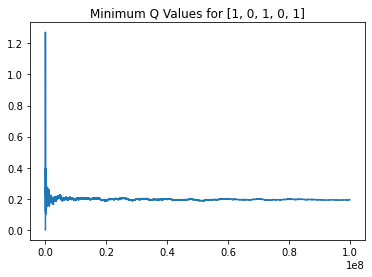

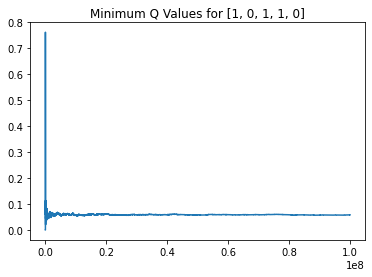

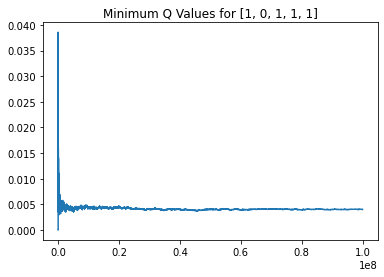

In [38]:
for i in range(16, 24):
    q_values = pd.read_csv(f'logs/q_values_window_{i}.csv').to_numpy()
    
    plt.figure()
    plt.plot(q_values.min(axis=-1))
    plt.title(f'Minimum Q Values for {str(list(map(lambda x: int(x), windows[i])))}')
    plt.show()

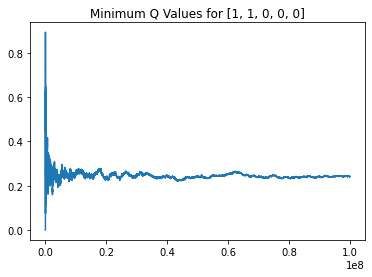

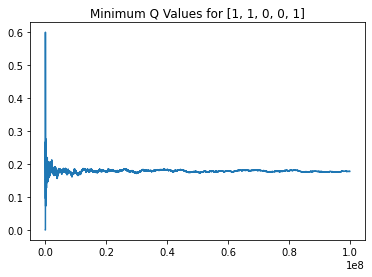

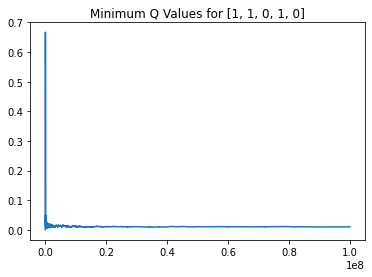

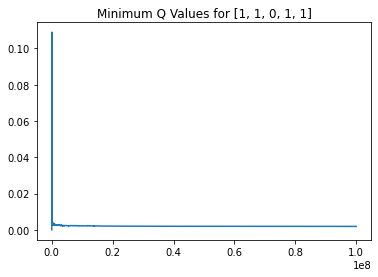

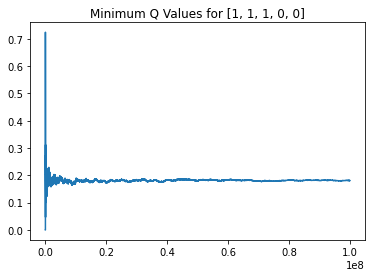

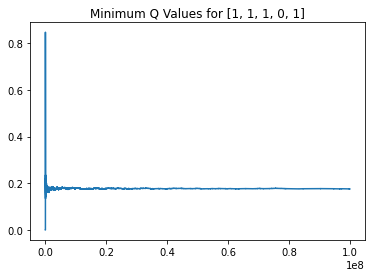

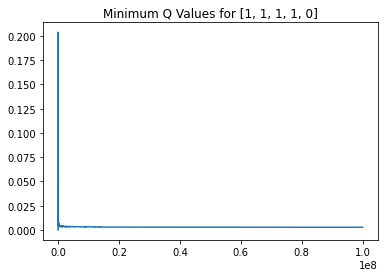

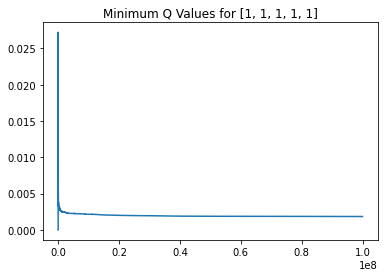

In [39]:
for i in range(24, 32):
    q_values = pd.read_csv(f'logs/q_values_window_{i}.csv').to_numpy()
    
    plt.figure()
    plt.plot(q_values.min(axis=-1))
    plt.title(f'Minimum Q Values for {str(list(map(lambda x: int(x), windows[i])))}')
    plt.show()

It seems that we need more iterations for some of the Q values to converge but I will not keep training because of the time requirements.

Now, let us see what is the optimal values and optimal policy.

The following code piece reads the last line of a file.

In [40]:
def get_last_line(filepath):
    with open(filepath, 'rb') as file:
        try: 
            file.seek(-2, os.SEEK_END)
            while file.read(1) != b'\n':
                file.seek(-2, os.SEEK_CUR)
        except OSError:
            file.seek(0)
        last_line = file.readline().decode()
        last_line = last_line.strip().split(',')
        return list(map(float, last_line))

In [41]:
q_values = np.array([
    get_last_line(f'logs/q_values_window_{i}.csv')
    for i in range(len(windows))
])

print(q_values)

[[1.10008275 0.74415707]
 [0.98407654 0.2182907 ]
 [0.7885403  0.07218613]
 [0.77072639 0.00751476]
 [1.16339221 0.63910096]
 [0.89861034 0.19810093]
 [0.77795069 0.05911305]
 [0.7680783  0.0036125 ]
 [0.92485151 0.2887018 ]
 [0.88417111 0.18041982]
 [0.78204271 0.01775444]
 [0.77082398 0.00196486]
 [0.9215125  0.18319491]
 [0.90412891 0.17807009]
 [0.7743873  0.00285738]
 [0.76810378 0.00184431]
 [1.18518777 0.72103981]
 [0.90115416 0.20433667]
 [0.78924303 0.06561679]
 [0.77076912 0.00472893]
 [1.1302816  0.6554907 ]
 [0.90835149 0.19385631]
 [0.77771243 0.05797542]
 [0.76812132 0.00400187]
 [0.93183087 0.2406746 ]
 [0.89967944 0.17770613]
 [0.78083119 0.01036574]
 [0.77077729 0.00193668]
 [0.92110831 0.18087733]
 [0.89697185 0.17559221]
 [0.77449307 0.0027156 ]
 [0.76809426 0.00184563]]


In [42]:
print(tabulate([
    [str(tuple(map(int, window))), q.min(), Actions(q.argmin()).name] 
     for window, q in zip(windows, q_values)],
    headers=['Window', 'Approximate Optimal Values', 'Optimal Policy'],
    tablefmt='fancy_grid'
))

╒═════════════════╤══════════════════════════════╤══════════════════╕
│ Window          │   Approximate Optimal Values │ Optimal Policy   │
╞═════════════════╪══════════════════════════════╪══════════════════╡
│ (0, 0, 0, 0, 0) │                   0.744157   │ REPAIR           │
├─────────────────┼──────────────────────────────┼──────────────────┤
│ (0, 0, 0, 0, 1) │                   0.218291   │ REPAIR           │
├─────────────────┼──────────────────────────────┼──────────────────┤
│ (0, 0, 0, 1, 0) │                   0.0721861  │ REPAIR           │
├─────────────────┼──────────────────────────────┼──────────────────┤
│ (0, 0, 0, 1, 1) │                   0.00751476 │ REPAIR           │
├─────────────────┼──────────────────────────────┼──────────────────┤
│ (0, 0, 1, 0, 0) │                   0.639101   │ REPAIR           │
├─────────────────┼──────────────────────────────┼──────────────────┤
│ (0, 0, 1, 0, 1) │                   0.198101   │ REPAIR           │
├─────────────────┼─